In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from scipy.stats import pearsonr, spearmanr

---

# Load data

We will look at 4 different state fairs that span a variety of climates and that were the largest of the US: Minnesota, Texas, New York and North Carolina.

In [2]:
attendance2 = pd.read_csv("state_fair_attendance_v4.csv", parse_dates = ["date"], dayfirst=True)
#attendance2['date'] = pd.to_datetime(attendance2['date'])

MN_prec = pd.read_csv("MN_Prism.csv", parse_dates = True)
NY_prec = pd.read_csv("NY_Prism.csv", parse_dates = True)
TX_prec = pd.read_csv("TX_Prism.csv", parse_dates = True)
NC_prec = pd.read_csv("NC_Prism.csv", parse_dates = True)

In [3]:
attendance2[attendance2['state']=='MN']

,state,year,date,attendance
0,MN,2018,2018-08-23,122695
1,MN,2018,2018-08-24,108059
2,MN,2018,2018-08-25,222194
3,MN,2018,2018-08-26,184715
4,MN,2018,2018-08-27,124438
5,MN,2018,2018-08-28,120209
6,MN,2018,2018-08-29,144940
7,MN,2018,2018-08-30,156764
8,MN,2018,2018-08-31,179402
9,MN,2018,2018-09-01,270426


In [4]:
MN_prec['state']='MN'
MN_prec['date'] = pd.to_datetime(MN_prec['date'])
NY_prec['state']='NY'
NY_prec['date'] = pd.to_datetime(NY_prec['date'])
TX_prec['state']='TX'
TX_prec['date'] = pd.to_datetime(TX_prec['date'])
NC_prec['state']='NC'
NC_prec['date'] = pd.to_datetime(NC_prec['date'])


In [5]:
MN_prec['date'] = MN_prec.date - pd.Timedelta(days=1)
NY_prec['date'] = NY_prec.date - pd.Timedelta(days=1)
TX_prec['date'] = TX_prec.date - pd.Timedelta(days=1)
NC_prec['date'] = NC_prec.date - pd.Timedelta(days=1)

In [6]:
attendance2.merge(MN_prec, right_on=['state','date'], left_on=['state','date'], how='left',suffixes=('_MN', '_y'))

,state,year,date,attendance,precip
0,MN,2018,2018-08-23,122695,2.79
1,MN,2018,2018-08-24,108059,32.78
2,MN,2018,2018-08-25,222194,0.00
3,MN,2018,2018-08-26,184715,0.72
4,MN,2018,2018-08-27,124438,5.10
...,...,...,...,...,...
355,NC,2013,2013-10-23,68252,NaN
356,NC,2013,2013-10-24,102176,NaN
357,NC,2013,2013-10-25,82163,NaN
358,NC,2013,2013-10-26,122223,NaN


In [7]:
df = attendance2.merge(MN_prec, on=['state','date'], how='left').merge(NC_prec, on=['state','date'], how='left',suffixes=(None, '_NC')).merge(TX_prec, on=['state','date'], how='left',suffixes=(None, '_TX')).merge(NY_prec, on=['state','date'], how='left',suffixes=(None, '_NY'))
df = df.fillna(0)
df['prec'] = df['precip']+ df['precip_NC']+df['precip_NY']+df['precip_TX']
df = df.drop(['precip','precip_NC','precip_NY', 'precip_TX'], axis=1)
df

,state,year,date,attendance,prec
0,MN,2018,2018-08-23,122695,2.79
1,MN,2018,2018-08-24,108059,32.78
2,MN,2018,2018-08-25,222194,0.00
3,MN,2018,2018-08-26,184715,0.72
4,MN,2018,2018-08-27,124438,5.10
...,...,...,...,...,...
355,NC,2013,2013-10-23,68252,0.00
356,NC,2013,2013-10-24,102176,0.00
357,NC,2013,2013-10-25,82163,0.00
358,NC,2013,2013-10-26,122223,0.00


In [8]:
df['date']=pd.to_datetime(df['date'])


# Scale
Use robust scaler for prec and attendance

In [9]:
from sklearn.preprocessing import QuantileTransformer

In [10]:
transformer_prec = [('prec_transform', QuantileTransformer(), ['prec'])]
col_transform = ColumnTransformer(transformers=transformer_prec, remainder = "drop" )

scaled_prec = col_transform.fit_transform(df)
df["scaled_prec"] = scaled_prec


C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (360). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [11]:

# scaling attendance sepaately
scaled_df = pd.DataFrame()
scaled_attendances = np.array([])
for state in df['state'].unique():
    state_df = df[df['state']==state]
    transformer_attendance = [('attendance_transform', QuantileTransformer(), ['attendance'])]
    col_transform = ColumnTransformer(transformers=transformer_attendance, remainder = "drop" )

    scaled_attendance = col_transform.fit_transform(state_df)
    state_df['scaled_attendance'] = scaled_attendance
    scaled_df = pd.concat([scaled_df,state_df], ignore_index=True)

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (36). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (87). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWar

In [12]:
scaled_df

,state,year,date,attendance,prec,scaled_prec,scaled_attendance
0,MN,2018,2018-08-23,122695,2.79,0.835655,0.285714
1,MN,2018,2018-08-24,108059,32.78,0.983287,0.228571
2,MN,2018,2018-08-25,222194,0.00,0.000000,0.885714
3,MN,2018,2018-08-26,184715,0.72,0.750696,0.742857
4,MN,2018,2018-08-27,124438,5.10,0.874652,0.342857
...,...,...,...,...,...,...,...
355,TX,2021,2021-10-13,43976,52.52,0.991643,0.115789
356,TX,2021,2021-10-14,86096,0.00,0.000000,0.557895
357,TX,2021,2021-10-15,148893,0.00,0.000000,0.842105
358,TX,2021,2021-10-16,164021,0.00,0.000000,0.884211


In [13]:
scaled_df[(scaled_df['state']=='NC')&(scaled_df['prec']>-1)]

,state,year,date,attendance,prec,scaled_prec,scaled_attendance
36,NC,2015,2015-10-15,50327,0.0,0.0,0.058140
37,NC,2015,2015-10-16,90954,0.0,0.0,0.534884
38,NC,2015,2015-10-17,126666,0.0,0.0,0.924419
39,NC,2015,2015-10-18,97906,0.0,0.0,0.616279
40,NC,2015,2015-10-19,63989,0.0,0.0,0.174419
...,...,...,...,...,...,...,...
118,NC,2013,2013-10-23,68252,0.0,0.0,0.220930
119,NC,2013,2013-10-24,102176,0.0,0.0,0.686047
120,NC,2013,2013-10-25,82163,0.0,0.0,0.476744
121,NC,2013,2013-10-26,122223,0.0,0.0,0.883721


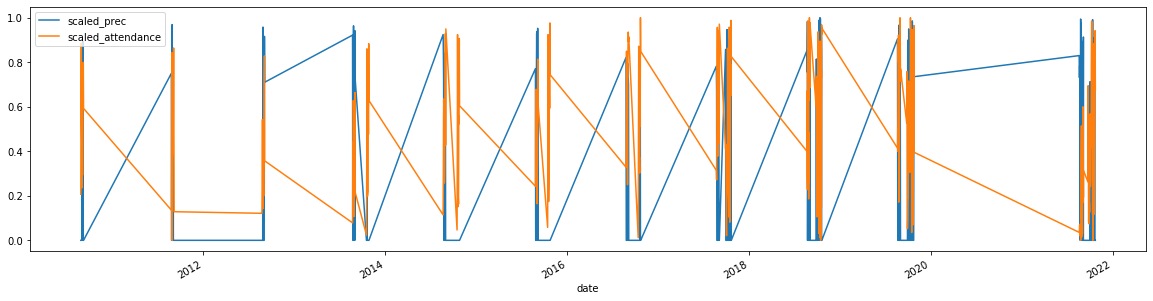

In [14]:
scaled_df.plot('date', ['scaled_prec', 'scaled_attendance'],figsize=(20,5))

In [15]:
# calculate Pearson's correlation before 2019
for state in scaled_df.state.unique():
    corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2019)]['prec'], scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2019)]['attendance'])
    print('Pearsons correlation {}: {}'.format(state,corr))

Pearsons correlation MN: -0.5192703618096502
Pearsons correlation NC: -0.15902435776281199
Pearsons correlation NY: -0.27159742259764513
Pearsons correlation TX: -0.2575030224499544


In [16]:
# calculate Pearson's correlation before 2020
for state in scaled_df.state.unique():
    corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2020)]['scaled_prec'], scaled_df[(scaled_df['state']==state)& (scaled_df['year']<2020)]['scaled_attendance'])
    print('Pearsons correlation {}: {}'.format(state,corr))

Pearsons correlation MN: -0.6071484983385812
Pearsons correlation NC: -0.0004154514431818977
Pearsons correlation NY: -0.15056774441087833
Pearsons correlation TX: -0.0462343694185572


In [17]:
# calculate Pearson's correlation before 2020 and with prec>1
for state in scaled_df.state.unique():
    try:
        corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2020) & (scaled_df['prec']>1)]['scaled_prec'], 
        scaled_df[(scaled_df['state']==state)& (scaled_df['year']<2020)& (scaled_df['prec']>1)]['scaled_attendance'])
        print('Pearsons correlation {}: {}'.format(state,corr))
    except:
        pass

Pearsons correlation MN: -0.7087792871354726
Pearsons correlation NC: 0.2563102760800219
Pearsons correlation NY: -0.20649826710346017
Pearsons correlation TX: -0.37424618138108573


---
# T test between 2 groups: rainy and non rainy days

In [18]:
import scipy
scipy.__version__

'1.7.2'

In [19]:
rain = scaled_df[scaled_df['prec']>0]['scaled_attendance']
no_rain = scaled_df[scaled_df['prec']==0]['scaled_attendance']

In [20]:
from scipy import stats

In [21]:
ttest = stats.ttest_ind(rain, no_rain, equal_var=False, alternative="less", permutations=10000,
                random_state=2)

print("P value:",ttest[1])

P value: 0.0183


P value is below commonly-agreed threshold of 0.05

---
# Optimized curve fit

In [22]:
from sklearn.preprocessing import MaxAbsScaler, RobustScaler 

from scipy.optimize import curve_fit

## Reprocessing dataframe

In [23]:
MN_df = df[df['state']=='MN']
TX_df = df[df['state']=='TX']
NC_df = df[df['state']=='NC']
NY_df = df[df['state']=='NY']


In [24]:
def preprocess_state_df(df):
    df = df[df['year']<2019]
    scaler_prec = MaxAbsScaler()
    X_train_prec = scaler_prec.fit_transform(np.array(df ['prec']).reshape(-1,1))
    scaler_att = MaxAbsScaler()
    X_train_att = scaler_att.fit_transform(np.array(df['attendance']).reshape(-1,1))
    df['scaled_prec'] = X_train_prec
    df['scaled_att'] = X_train_att
    df = df[df['prec']>0]

    q_low = df["attendance"].quantile(0.0)
    q_hi  = df["attendance"].quantile(1)
    df_filtered = df[(df["attendance"] < q_hi) & (df["attendance"] > q_low)]
    return df_filtered, scaler_prec, scaler_att

In [25]:
MN_df_scaled, MN_scaler_prec, MN_scaler_att = preprocess_state_df(MN_df)

NC_df_scaled, NC_scaler_prec, NC_scaler_att = preprocess_state_df(NC_df)

NY_df_scaled, NY_scaler_prec, NY_scaler_att = preprocess_state_df(NY_df)


C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [26]:
TX_df_scaled, TX_scaler_prec, TX_scaler_att = preprocess_state_df(TX_df)
px.scatter(TX_df_scaled, x='scaled_prec',y='scaled_att')
px.scatter(TX_df_scaled, x='prec',y='attendance')

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# assuming curve is in the form below
# sigmoid
# https://math.stackexchange.com/questions/1328566/slow-decreasing-function-that-exhibits-asymptotic-behaviour 
def func(t, a, b, c):
    #return a + b * np.log(c*t)
    #return a * 1/(1 + np.exp(b*t+c))
    return a*np.exp(-b*t-c) 



In [28]:
def fit_curve(state_df):
    x = np.array(state_df["scaled_prec"])
    y = np.array(state_df["scaled_att"])
    popt, pcov = curve_fit(func, x, y,maxfev=5000, bounds=(0, np.inf))
    p,a = zip(*sorted(zip(x, func(x, *popt))))
    plt.plot(p,a, label="fit: a={}, b={}, c={}".format(popt[0],popt[1],popt[2]))
    plt.scatter(x,y)

    plt.xlabel('Scaled precipitation')
    plt.ylabel('Scaled attendance')
    plt.show()
    return popt

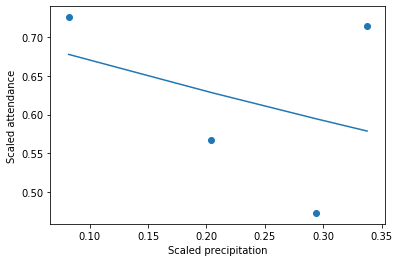

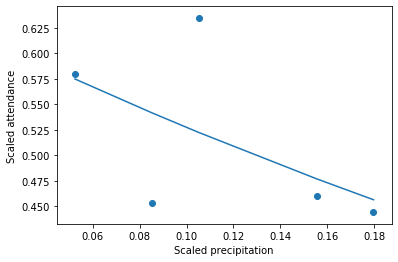

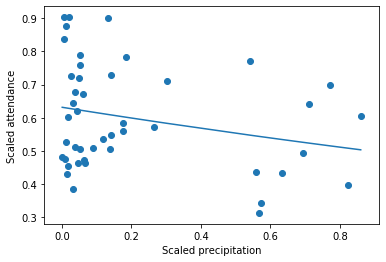

In [29]:
popt_NC = fit_curve(NC_df_scaled)
popt_MN = fit_curve(MN_df_scaled)
popt_NY = fit_curve(NY_df_scaled)


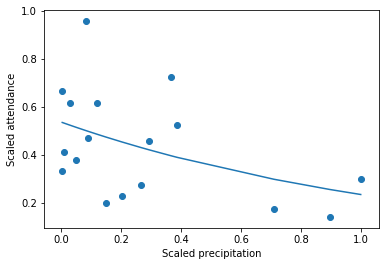

array([1.48084916, 0.82617433, 1.01660853])

In [30]:
popt_TX = fit_curve(TX_df_scaled)
popt_TX

In [31]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=p, y=a,
                    mode='lines',
                    name='lines'))

fig.add_trace(go.Scatter(x=x, y=y,
                    mode='markers', name='markers'))

# Edit the layout
fig.update_layout(title='Scaled',
                   xaxis_title='Scaled precipitation',
                   yaxis_title='Scaled attendance')


fig.show()

NameError: name 'p' is not defined

---
# vendors - revenue loss

In [32]:
# old
def adjust_vendor_revenue(df,precipitation, gross_revenue, popt):
    # gross revenue per day
    # optimised_curve_fit
    # how many more or less people than average, assuming an average attendance gives the same revenue

    scaled_avg_attendance = df['scaled_att'].mean()
    y_pred = func(precipitation, popt[0],popt[1],popt[2]) #returns scaled attendance
    sf = (y_pred-scaled_avg_attendance)/scaled_avg_attendance

    new_revenue = sf*gross_revenue+gross_revenue

    return (new_revenue)

In [33]:
def adjust_vendor_revenue(df,precipitation, gross_revenue, popt, scaler_prec):
    # gross revenue per day
    # optimised_curve_fit
    # how many more or less people than average, assuming an average attendance gives the same revenue

    #scaled_avg_attendance = df['scaled_att'].mean()
    
    scaled_prec = scaler_prec.transform(np.array(precipitation).reshape(-1, 1))
    no_rain_att =  func(0, popt[0],popt[1],popt[2]) #returns scaled attendance no rain
    y_pred = func(scaled_prec[0,0], popt[0],popt[1],popt[2]) #returns scaled attendance with rain
    sf = (y_pred)/no_rain_att

    new_revenue = sf*gross_revenue

    return (new_revenue)

In [34]:
adjust_vendor_revenue(TX_df_scaled, 3,10000, popt_TX, TX_scaler_prec)

9636.083518210091

In [35]:
def plot_adj_rev(scaled_df, popt, scaler_prec):
    adj_rev = []
    for i in range(100):
        adj_rev.append(adjust_vendor_revenue(scaled_df, i,10000, popt, scaler_prec))

    fig, ax = plt.subplots()


    plt.xlabel("Daily rainfall")
    plt.ylabel("Expected daily gross revenue")
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')


    ax.plot(list(range(100)), adj_rev)


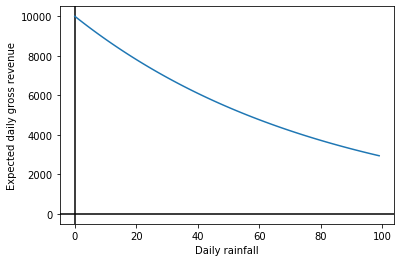

In [36]:
plot_adj_rev(TX_df_scaled, popt_TX,TX_scaler_prec)

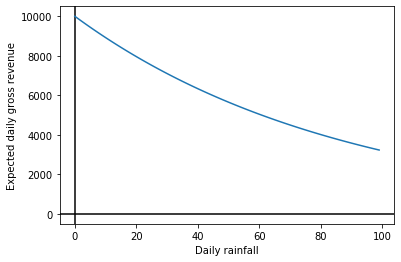

In [37]:
plot_adj_rev(NY_df_scaled, popt_NY, NY_scaler_prec)

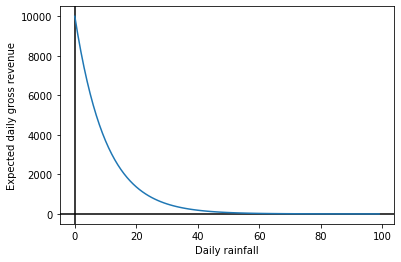

In [38]:
plot_adj_rev(NC_df_scaled, popt_NC,NC_scaler_prec)

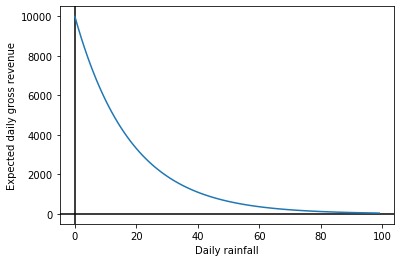

In [39]:
plot_adj_rev(MN_df_scaled, popt_MN, MN_scaler_prec)

Some assumptions:
* The revenue from concessions and admissions is proportional to the attendance rate
* Attendance rate is predicted by rainfall in a decreasing-log
* Expenses do not change depending on rainfall, assuming the rainfall is unexpected
* Data for US, 2015-2019


## Vendor simulation (with costs)

In [52]:
def rainfall_profit(df_scaled, popt, rainfall, scaler_prec, daily_revenue, percent_commission=0.15, percent_sales_tax=0.0738,percent_admission=0.02, percent_labour=0.18, percent_food=0.25, percent_income_tax = 0.12, extra_costs=0):
    adjusted_rev = adjust_vendor_revenue(df_scaled, rainfall,daily_revenue, popt, scaler_prec)
    commission = percent_commission*adjusted_rev
    sales_tax = percent_sales_tax*adjusted_rev

    admission = percent_admission*daily_revenue
    labour = percent_labour*daily_revenue
    food_cost = percent_food*daily_revenue

    pre_tax_profit = adjusted_rev - commission - sales_tax - admission - labour - food_cost - extra_costs


    calc_income_tax = lambda a : a*percent_income_tax if a > 0 else 0
    income_tax = calc_income_tax(pre_tax_profit)

    net_profit = pre_tax_profit - income_tax
    return net_profit


In [ ]:
# save dfs
MN_df_scaled.to_csv("MN_df_scaled.csv", index=False)
TX_df_scaled.to_csv("TX_df_scaled.csv", index=False)
NC_df_scaled.to_csv("NC_df_scaled.csv", index=False)
NY_df_scaled.to_csv("NY_df_scaled.csv", index=False)


In [41]:
rainfall_profit(MN_df_scaled, popt_MN,0,MN_scaler_prec,70000, extra_costs=0)

1545.6861538461544

In [45]:
# assuming no extra costs
# per day
def plot_profit(df_scaled, popt, scaler_prec,revenue, extra_costs=0):
    profit_list = []
    for i in range(1,120):
        profit_list.append(rainfall_profit(df_scaled, popt,i,scaler_prec, revenue, extra_costs=0))

    fig, ax = plt.subplots(figsize=(14,4))


    plt.xlabel("Rainfall for day")
    plt.ylabel("Profit")
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')


    ax.set_xticks(np.arange(0, 120, 5))


    ax.plot(list(range(1,120)), profit_list)

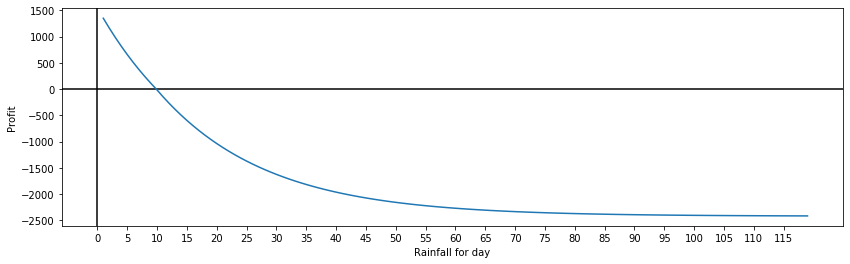

In [46]:
plot_profit(MN_df_scaled, popt_MN, MN_scaler_prec, 70000, extra_costs=0)

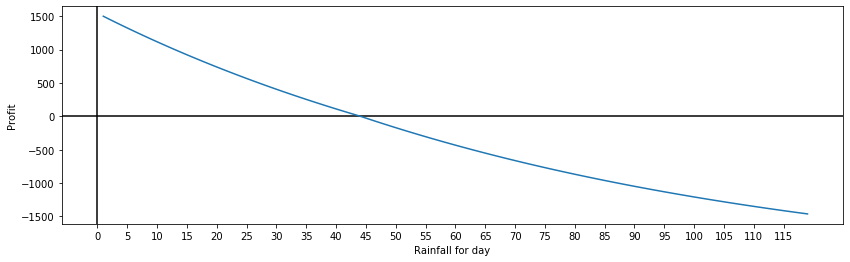

In [47]:
plot_profit(TX_df_scaled, popt_TX, TX_scaler_prec, 70000, extra_costs=0)

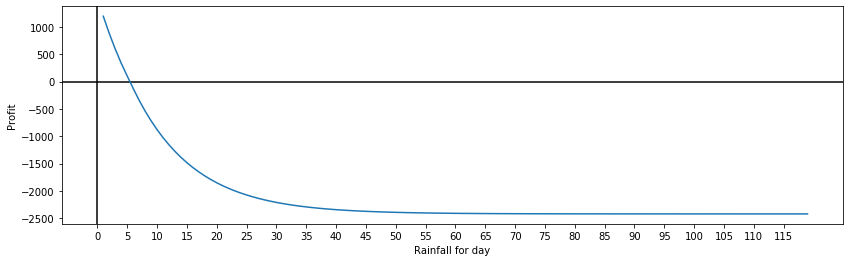

In [48]:
plot_profit(NC_df_scaled, popt_NC,NC_scaler_prec, 70000, extra_costs=0)

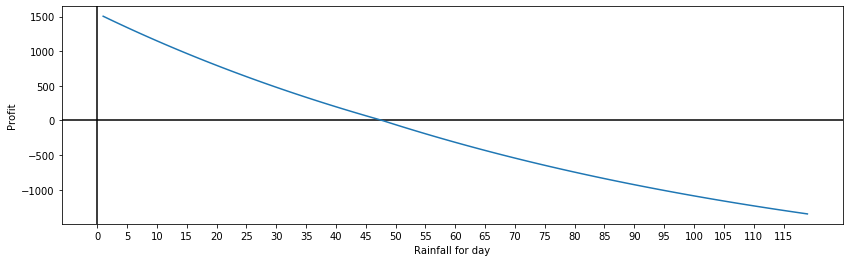

In [49]:
plot_profit(NY_df_scaled, popt_NY, NY_scaler_prec, 70000, extra_costs=0)

In [53]:
def total_profit_fair(df_scaled, popt, scaler_prec, total_revenue, prec_list, extra_costs=0):
    profit_list = []
    daily_revenue = total_revenue/len(prec_list)
    for prec in prec_list:
        profit_list.append(rainfall_profit(df_scaled, popt,prec, scaler_prec, daily_revenue, extra_costs=0))
    
    total_profit = sum(profit_list)
    rainy_days = len([x for x in prec_list if x > 0])

    print('Total days: {}'.format(len(prec_list)))
    print('Rainy days: {}'.format(rainy_days))
    print('Daily Profit: {}'.format(profit_list))
    print('Total Profit: {}'.format(total_profit))

    return prec_list, profit_list, rainy_days, total_profit

    

In [56]:
total_profit_fair(NY_df_scaled, popt_NY, NY_scaler_prec, 70000, [100,60,60,0,0,5,2,0,0,8,10,30,0,0],extra_costs=0)

Total days: 14
Rainy days: 8
Daily Profit: [-1009.831993004075, -292.6622542808798, -292.6622542808798, 1435.28, 1435.28, 1245.9167752806925, 1358.2361244132842, 1435.28, 1435.28, 1137.3765585160331, 1067.0529622863658, 445.422371764482, 1435.28, 1435.28]
Total Profit: 12270.528290695023


([100, 60, 60, 0, 0, 5, 2, 0, 0, 8, 10, 30, 0, 0],
 [-1009.831993004075,
  -292.6622542808798,
  -292.6622542808798,
  1435.28,
  1435.28,
  1245.9167752806925,
  1358.2361244132842,
  1435.28,
  1435.28,
  1137.3765585160331,
  1067.0529622863658,
  445.422371764482,
  1435.28,
  1435.28],
 8,
 12270.528290695023)

In [66]:
total_profit_fair(MN_df_scaled, popt_MN, MN_scaler_prec, 70000, [100,150,100,50,4,5,2,0,0,8,10,30,0,1],extra_costs=3000)

Total days: 14
Rainy days: 11
Daily Profit: [-2234.4868091796047, -2249.019201302364, -2234.4868091796047, -2004.6294769660508, 758.3982876670011, 611.2790835103849, 1078.1688808670065, 1435.28, 1435.28, 215.66922240564978, -15.81366127893125, -1509.5923619469527, 1435.28, 1251.795633304722]
Total Profit: -2026.8772120987426


([100, 150, 100, 50, 4, 5, 2, 0, 0, 8, 10, 30, 0, 1],
 [-2234.4868091796047,
  -2249.019201302364,
  -2234.4868091796047,
  -2004.6294769660508,
  758.3982876670011,
  611.2790835103849,
  1078.1688808670065,
  1435.28,
  1435.28,
  215.66922240564978,
  -15.81366127893125,
  -1509.5923619469527,
  1435.28,
  1251.795633304722],
 11,
 -2026.8772120987426)

In [69]:
scalers_dict = {'NY':NY_scaler_prec,
'NC':NC_scaler_prec,
'TX':TX_scaler_prec,
'MN':MN_scaler_prec}

In [77]:
def total_profit_fair_us(total_revenue, scalers_dict, prec_list, extra_costs=0):
    profit_list_MN = []
    profit_list_TX = []
    profit_list_NC = []
    profit_list_NY = []
    daily_revenue = total_revenue/len(prec_list)
    for prec in prec_list:
        profit_list_MN.append(rainfall_profit(MN_df_scaled, popt_MN,prec, scalers_dict['MN'], daily_revenue, extra_costs=0))
        profit_list_TX.append(rainfall_profit(TX_df_scaled, popt_TX,prec, scalers_dict['TX'],daily_revenue, extra_costs=0))
        profit_list_NC.append(rainfall_profit(NC_df_scaled, popt_NC,prec, scalers_dict['NC'], daily_revenue, extra_costs=0))
        profit_list_NY.append(rainfall_profit(NY_df_scaled, popt_NY,prec,scalers_dict['NY'], daily_revenue, extra_costs=0))
    
    avg_profit_list = np.average(np.array([profit_list_MN, profit_list_TX, profit_list_NC, profit_list_NY]), axis=0)
    
    total_profit_MN = sum(profit_list_MN)
    total_profit_TX = sum(profit_list_TX)
    total_profit_NC = sum(profit_list_NC)
    total_profit_NY = sum(profit_list_NY)

    avg_total_profit = (total_profit_MN + total_profit_TX + total_profit_NC + total_profit_NY)/4

    rainy_days = len([x for x in prec_list if x > 0])

    print('Total days: {}'.format(len(prec_list)))
    print('Rainy days: {}'.format(rainy_days))
    print('Average Daily Profit: {}'.format(avg_profit_list))
    print('Average Total Profit: {}'.format(avg_total_profit))

    return prec_list, avg_profit_list, rainy_days, avg_total_profit

In [78]:
total_profit_fair_us(70000, scalers_dict,[0,0,0,0,0,5,2,100,100,100,10,30,30,0],extra_costs=0)

Total days: 14
Rainy days: 8
Average Daily Profit: [ 1435.28        1435.28        1435.28        1435.28
  1435.28         796.0641474   1151.79285458 -1654.04234146
 -1654.04234146 -1654.04234146   318.51987727  -685.19435113
  -685.19435113  1435.28      ]
Average Total Profit: 4545.541152625189


([0, 0, 0, 0, 0, 5, 2, 100, 100, 100, 10, 30, 30, 0],
 array([ 1435.28      ,  1435.28      ,  1435.28      ,  1435.28      ,
         1435.28      ,   796.0641474 ,  1151.79285458, -1654.04234146,
        -1654.04234146, -1654.04234146,   318.51987727,  -685.19435113,
         -685.19435113,  1435.28      ]),
 8,
 4545.541152625189)

In [79]:
# save scalers
from sklearn.externals import joblib

for state, scaler in scalers_dict.items():
    scaler_filename = "{}_scaler_prec.save".format(state)
    joblib.dump(scaler, scaler_filename) 

# And now to load...

#scaler = joblib.load(scaler_filename) 

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



# Add insurance

In [ ]:
def add_insurance(prec_list, profit_list, threshold, payout, premium):
    paid = False
    new_profit_list = profit_list.copy()
    for i in range(len(prec_list)):
        if (prec_list[i]>threshold) and (paid==False):
            new_profit_list[i] = profit_list[i] + payout
            paid = True
        elif (paid==True):
            new_profit_list[i] = profit_list[i]
        elif (paid==False):
            new_profit_list[i] = profit_list[i] - premium

    return new_profit_list


# Find average fair duration

In [ ]:
date_df = scaled_df.groupby(['state','year'],as_index=False)['date'].agg(np.ptp) 
date_df

,state,year,date
0,MN,2018,11 days
1,MN,2019,11 days
2,MN,2021,11 days
3,NC,2013,10 days
4,NC,2014,10 days
5,NC,2015,10 days
6,NC,2016,10 days
7,NC,2017,10 days
8,NC,2018,9 days
9,NC,2019,10 days


In [ ]:
date_df['date'].mean()

Timedelta('12 days 20:18:27.692307692')

In [ ]:
scaled_df['date']

0     2018-08-23
1     2018-08-24
2     2018-08-25
3     2018-08-26
4     2018-08-27
         ...    
355   2021-10-13
356   2021-10-14
357   2021-10-15
358   2021-10-16
359   2021-10-17
Name: date, Length: 360, dtype: datetime64[ns]

# Plot outputs

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
def plotly_prec_profit(prec_list, profit_list):

    fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True)
    

    fig.add_trace(
        go.Bar(x=[x for x in range(1,len(prec_list)+1)], y=prec_list,name="Precipitation"),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=[x for x in range(1,len(profit_list)+1)], y=profit_list, name = "Profit"),
        row=2, col=1
    )


    fig.update_layout(title_text="Daily Precipitation and Profit",)

    # Update xaxis properties
    fig.update_xaxes(title_text="Day",row=1, col=1)
    fig.update_xaxes(title_text="Day", row=2, col=1)


    # Update yaxis properties
    fig.update_yaxes(title_text="Precipitation (mm)", row=1, col=1)
    fig.update_yaxes(title_text="Expected Profit (USD)", row=2, col=1)

    fig.show()
    

In [ ]:
prec_list, avg_profit_list, rainy_days, total_profit = total_profit_fair_us(70000, [0,0,0,0,0,5,2,30,30,50,10,30,30,0],extra_costs=0)

plotly_prec_profit(prec_list,avg_profit_list)

Total days: 14
Rainy days: 8
Average Daily Profit: [ 1992.80065354  1992.80065354  1992.80065354  1992.80065354
  1992.80065354 -1906.37492966 -1068.84025513 -2249.62190108
 -2249.62190108 -2249.99805219 -2174.01635487 -2249.62190108
 -2249.62190108  1992.80065354]
Average Total Profit: -17763.653099752315


In [ ]:
new_profit_lst = add_insurance(prec_list,avg_profit_list,40,20000)
plotly_prec_profit(prec_list,new_profit_lst)